In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans  
from sklearn.metrics import silhouette_score, silhouette_samples
import time

# 1/ Dataset upload/overview

In [14]:
df = pd.read_csv("data/kaya_dataset.csv")
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7745 entries, 0 to 7744
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   country              7745 non-null   object 
 1   year                 7745 non-null   int64  
 2   iso_code             7745 non-null   object 
 3   co2                  7745 non-null   float64
 4   energy               7745 non-null   float64
 5   gdp                  7745 non-null   float64
 6   population           7745 non-null   float64
 7   co2_per_unit_energy  7745 non-null   float64
 8   energy_per_gdp       7745 non-null   float64
 9   gdp_per_capita       7745 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 605.2+ KB
None


,year,co2,energy,gdp,population,co2_per_unit_energy,energy_per_gdp,gdp_per_capita
count,7745.000000,7745.000000,7.745000e+03,7.745000e+03,7.745000e+03,7745.000000,7745.000000,7745.000000
mean,1997.914009,169.430360,7.407782e+11,4.259151e+11,4.002676e+07,0.239455,1.674191,13025.601709
std,15.104324,683.710379,2.786040e+12,1.488989e+12,1.350935e+08,0.200058,1.631089,14718.564983
min,1965.000000,0.022000,9.765923e+07,1.642060e+08,6.408200e+04,0.018000,0.078000,361.188725
25%,1986.000000,3.691000,1.850453e+10,1.803369e+10,3.593782e+06,0.186000,0.767000,2808.878751
50%,1999.000000,20.870000,8.890039e+10,6.434611e+10,9.754398e+06,0.221000,1.245000,7828.856656
75%,2011.000000,84.838000,4.128210e+11,2.542891e+11,2.810118e+07,0.261000,2.053000,18309.742796
max,2022.000000,11711.808000,4.451869e+13,2.696602e+13,1.426437e+09,10.689000,25.253000,163531.400281


# 2/ data and feature selection

In [28]:
# countries selection :
countries = df.country.unique()
# year selection :
# years = df.year.unique()
years = [2022]  # only 2022
# common columns :
# cols = df.columns.tolist() # select all
cols = ['country', 'year', 'iso_code']
# features selection :
features_1 = ['co2', 'energy', 'gdp', 'population']
features_2 = ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita'] 
features_3 = ['co2_per_unit_energy', 'energy_per_gdp', 'gdp_per_capita', 'population']
features = features_1

# kmeans parameters
kmax = 20 # max number of clusters
rs = 42 # seed for random functions (center first position)

# 6/ Results

[<Figure size 1500x500 with 2 Axes>]

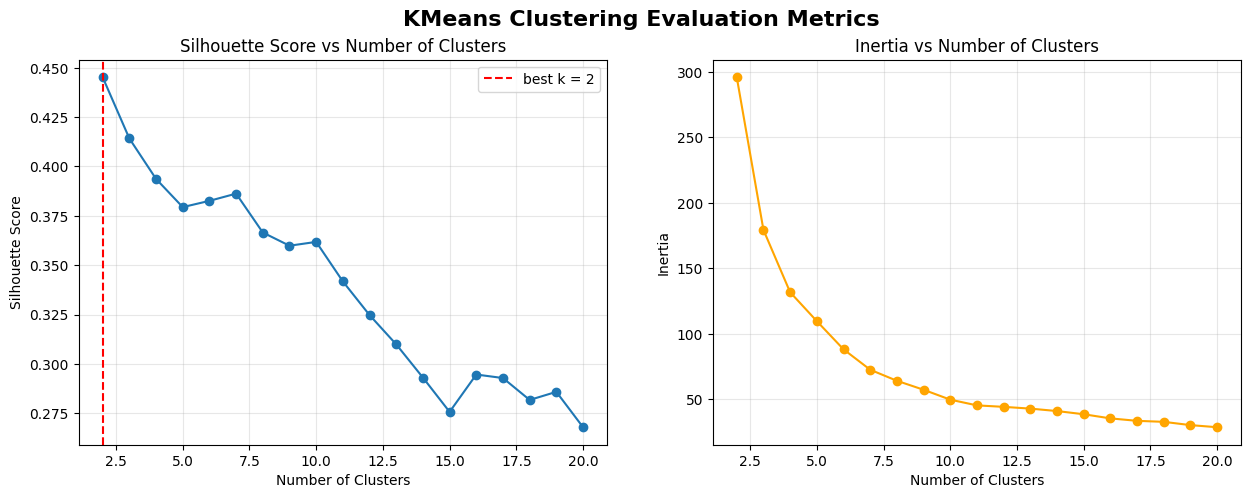

In [29]:
def kmeans_main(df, years, countries, cols, features, kmax, seed):
    X =  preprocessing(df, years, countries, cols, features)
    range_n_clusters = list(range(2, kmax + 1))
    figs = []
    silhouette_scores = []
    inertia_scores = []

    for k in range_n_clusters:
        # KMeans training
        cluster_labels, centers, silhouette_avg, inertia, sample_silhouette_values= kmeans_training(X, k, seed)
        
        # plotting sihouette graph [optional]
        # fig1 = kmeans_silhouettes(k, cluster_labels, silhouette_avg, inertia, sample_silhouette_values)
        # plotting 2D clusters [optional]
        # fig2 = kmeans_clusters(X, k, features, centers, cluster_labels)
        # figs.append((fig1, fig2))
        silhouette_scores.append(silhouette_avg)
        inertia_scores.append(inertia)
    
    fig = display_scores(range_n_clusters, silhouette_scores, inertia_scores)
    figs.append(fig)
    return figs
    

kmeans_main(df, years, countries, cols, features, kmax, seed=rs)

# 3/ Preprocessing

In [25]:
def preprocessing(df:pd.DataFrame, years:list, countries:list, cols:list, features:list) -> pd.DataFrame:
    """ select data and features to process and log-transform floats"""
    dfl = df.copy()
    dfl = dfl[dfl['year'].isin(years)]
    dfl = dfl[dfl['country'].isin(countries)]
    dfl = dfl[cols+features]
    dfl.reset_index(drop=True, inplace=True)
    
    # columns to log-transform (floats) :
    features = dfl.select_dtypes(include=['float64']).columns.tolist()
    # floats = dfl.dtypes[df.dtypes == 'float64'].index.tolist() # same result

    # log transform because asyetrical distributions
    for feat in features:
        dfl[feat] = np.log1p(dfl[feat])  # log1p to handle zero values safely 
        
    # standardisation :    
    scaler = StandardScaler()
    X = scaler.fit_transform(dfl[features])
    
    return X

# test preprocessing: 
# X = preprocessing(df, years, countries, cols, features)
# print(X.shape)
# X


# 4/ Training

In [17]:
def kmeans_training(X, k, seed):
   """ kmeans training : dataset X, k clusters"""      

   clusterer = KMeans(n_clusters=k, tol=1e-4, random_state=seed)
   cluster_labels = clusterer.fit_predict(X)
   centers = clusterer.cluster_centers_

   # Calcul du score de silhouette moyen et des scores d'inertie
   silhouette_avg = silhouette_score(X, cluster_labels)
   inertia = clusterer.inertia_
   
   
   # On calcule le score de silhouette pour chaque échantillon
   sample_silhouette_values = silhouette_samples(X, cluster_labels)
   
   return cluster_labels, centers, silhouette_avg, inertia, sample_silhouette_values

# 5/ Silhouettes, clusters, inertia display

In [18]:
def kmeans_silhouettes(k, cluster_labels, silhouette_avg, inertia, sample_silhouette_values):
    """ display silhouette charts for each of the k clusters"""
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10, 7)


    ax.set_xlim([-0.1, 1])
    ax.set_ylim([0, len(X) + (k + 1) * 10])

    # # On peut changer le random_state pour voir l'impact sur les clusters
    # clusterer = KMeans(n_clusters=k, tol=1e-4, random_state=seed)
    # cluster_labels = clusterer.fit_predict(X)
    # centers = clusterer.cluster_centers_

    # # Calcul du score de silhouette moyen et des scores d'inertie
    # silhouette_avg = silhouette_score(X, cluster_labels)
    # inertia = clusterer.inertia_
    
    
    # # On calcule le score de silhouette pour chaque échantillon
    # sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(k):
        # On trie les valeurs de silhouette pour chaque cluster
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # On calcule la nouvelle valeur de y_lower pour le prochain plot
        y_lower = y_upper + 10
    
    ax.set_title(f"Coef de silhouette moyen = {silhouette_avg:.3f}, inertie = {inertia:.0f}", color='red', fontsize=12)
    ax.set_xlabel("Valeurs des coefficients de silhouette")
    ax.set_ylabel("Label du cluster")

    # La ligne rouge est la moyenne de tous les coefficients de silhouette
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    
    return fig, ax


In [19]:
def kmeans_clusters(X, k, features, centers, cluster_labels):
    """display 2D views (feature1 x feature2) showing k centers and k clusters, for all features"""
    k = centers.shape[0]
    n_graph = len(features)*(len(features)-1)//2
    fig, ax = plt.subplots((n_graph+2)//3, 3, figsize=(15, 5 * ((n_graph+2)//3)), squeeze=False)
    
    i = 0
    for ix, feature_x in enumerate(features):
        for ixy, feature_y in enumerate(features[ix + 1:]):
            iy = ix + 1 + ixy
            colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
            ax[i//3, i%3].scatter(
                X[:, ix], X[:, iy], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
            )

            # On affiche le numéro du cluster à son centre
            # On dessine un cercle blanc autour des points pour les faire ressortir
            ax[i//3, i%3].scatter(
                centers[:, ix],
                centers[:, iy],
                marker="o",
                c="white",
                alpha=1,
                s=200,
                edgecolor="k",
            )

            for ic, c in enumerate(centers):
                ax[i//3, i%3].scatter(c[ix], c[iy], marker="$%d$" % ic, alpha=1, s=50, edgecolor="k")
            
            ax[i//3, i%3].set_title("Clusters formés par KMeans")
            ax[i//3, i%3].set_xlabel(f"{features[ix]}, [{ix}]")
            ax[i//3, i%3].set_ylabel(f"{features[iy]}, [{iy}]")

            plt.suptitle(
                "Visualisation des clusters pour KMeans sur des données avec n_clusters = %d"
                % k,
                fontsize=14,
                fontweight="bold",
            )
            i += 1
    return fig

In [20]:
def display_scores(range_n_clusters, silhouette_scores, inertia_scores):
    """ display silhouette and inertia scores as a function of k (number of clusters)"""
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    best_k = range_n_clusters[int(np.argmax(silhouette_scores))]

    ax[0].plot(range_n_clusters, silhouette_scores, marker='o')
    ax[0].set_title("Silhouette Score vs Number of Clusters")
    ax[0].set_xlabel("Number of Clusters")
    ax[0].set_ylabel("Silhouette Score")
    ax[0].axvline(best_k, color='red', linestyle='--', label=f"best k = {best_k}")
    ax[0].legend()
    ax[0].grid(alpha=0.3)

    ax[1].plot(range_n_clusters, inertia_scores, marker='o', color='orange')
    ax[1].set_title("Inertia vs Number of Clusters")
    ax[1].set_xlabel("Number of Clusters")
    ax[1].set_ylabel("Inertia")
    ax[1].grid(alpha=0.3)

    plt.suptitle("KMeans Clustering Evaluation Metrics", fontsize=16, fontweight='bold')
    
    return fig

[((<Figure size 1000x700 with 1 Axes>,
   <Axes: title={'center': 'Coef de silhouette moyen = 0.445, inertie = 296'}, xlabel='Valeurs des coefficients de silhouette', ylabel='Label du cluster'>),
  <Figure size 1500x1000 with 6 Axes>),
 ((<Figure size 1000x700 with 1 Axes>,
   <Axes: title={'center': 'Coef de silhouette moyen = 0.414, inertie = 179'}, xlabel='Valeurs des coefficients de silhouette', ylabel='Label du cluster'>),
  <Figure size 1500x1000 with 6 Axes>),
 ((<Figure size 1000x700 with 1 Axes>,
   <Axes: title={'center': 'Coef de silhouette moyen = 0.394, inertie = 132'}, xlabel='Valeurs des coefficients de silhouette', ylabel='Label du cluster'>),
  <Figure size 1500x1000 with 6 Axes>),
 ((<Figure size 1000x700 with 1 Axes>,
   <Axes: title={'center': 'Coef de silhouette moyen = 0.379, inertie = 110'}, xlabel='Valeurs des coefficients de silhouette', ylabel='Label du cluster'>),
  <Figure size 1500x1000 with 6 Axes>),
 ((<Figure size 1000x700 with 1 Axes>,
   <Axes: title={

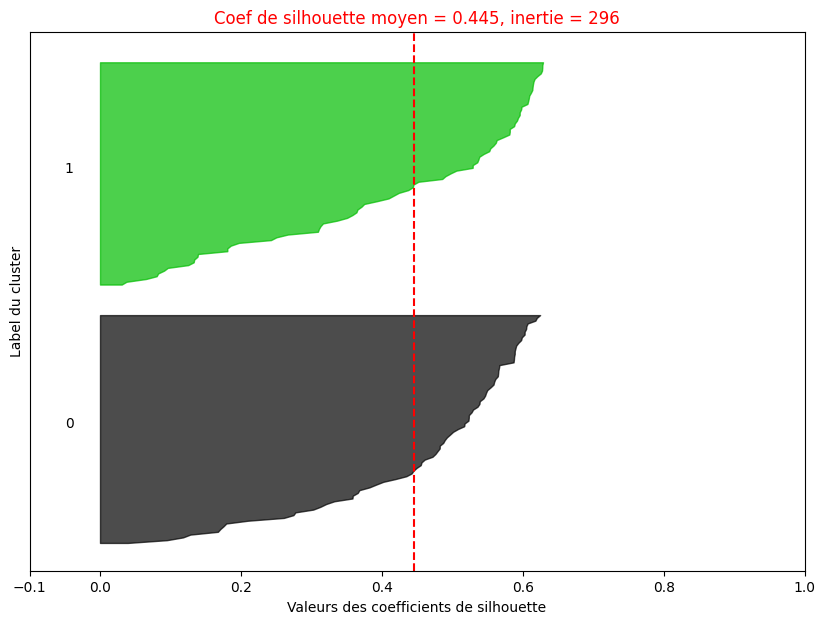

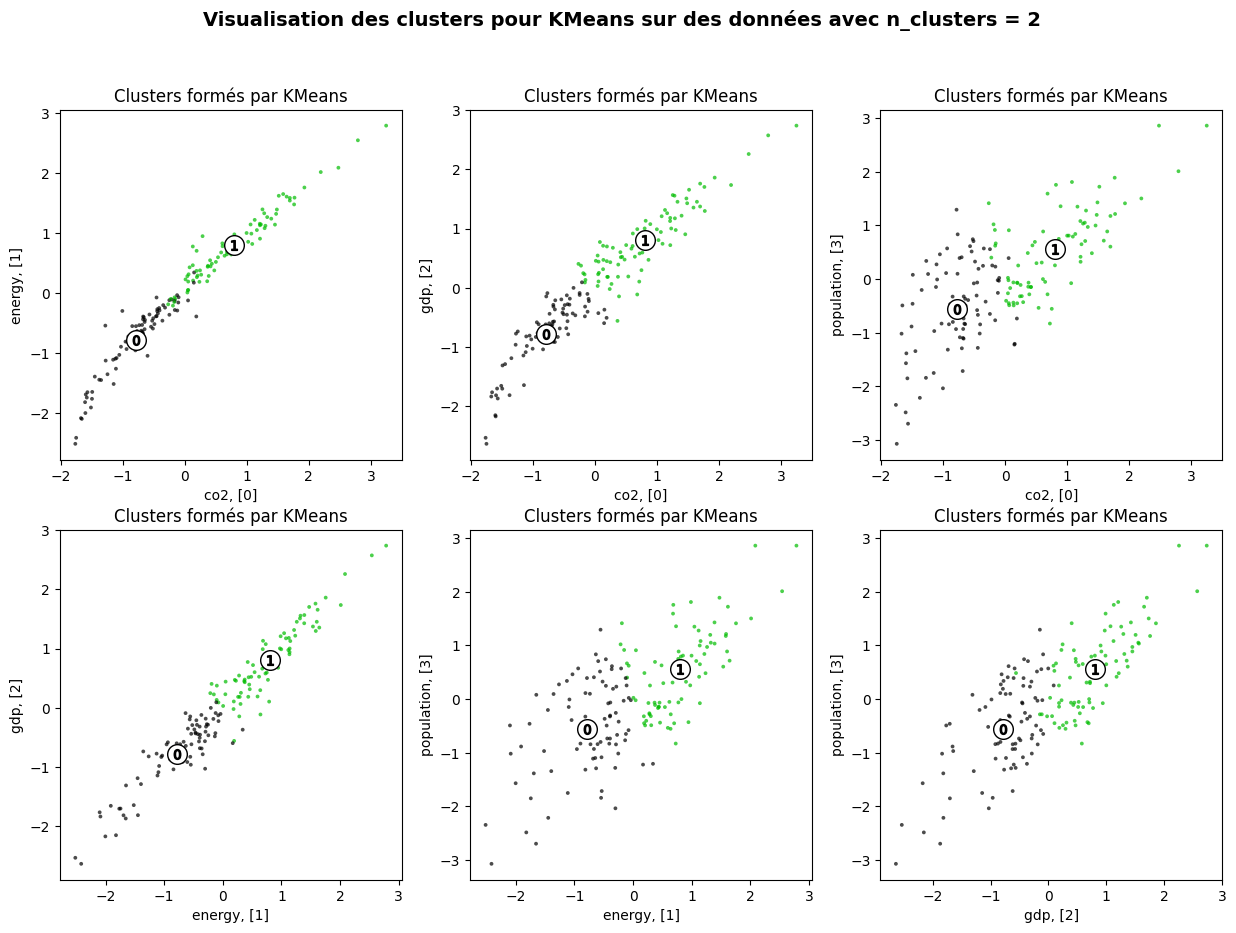

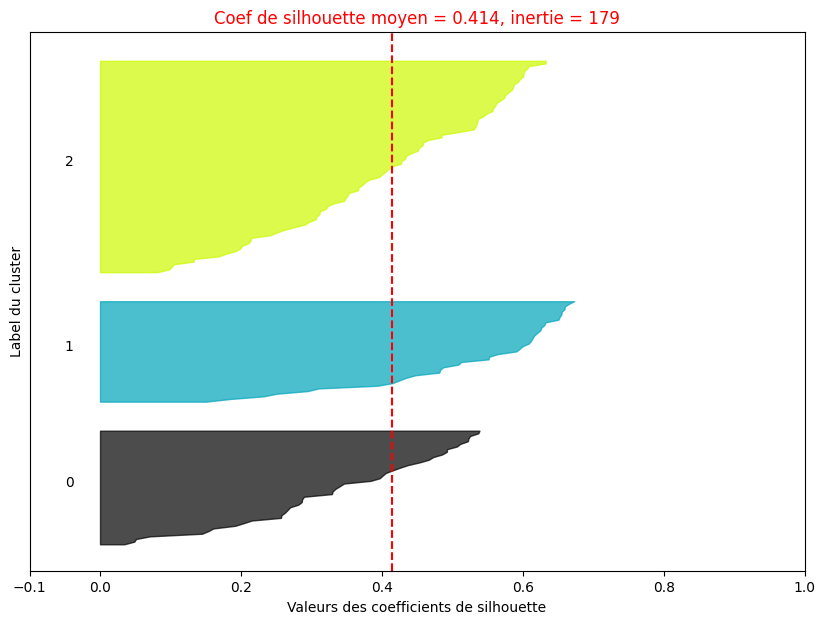

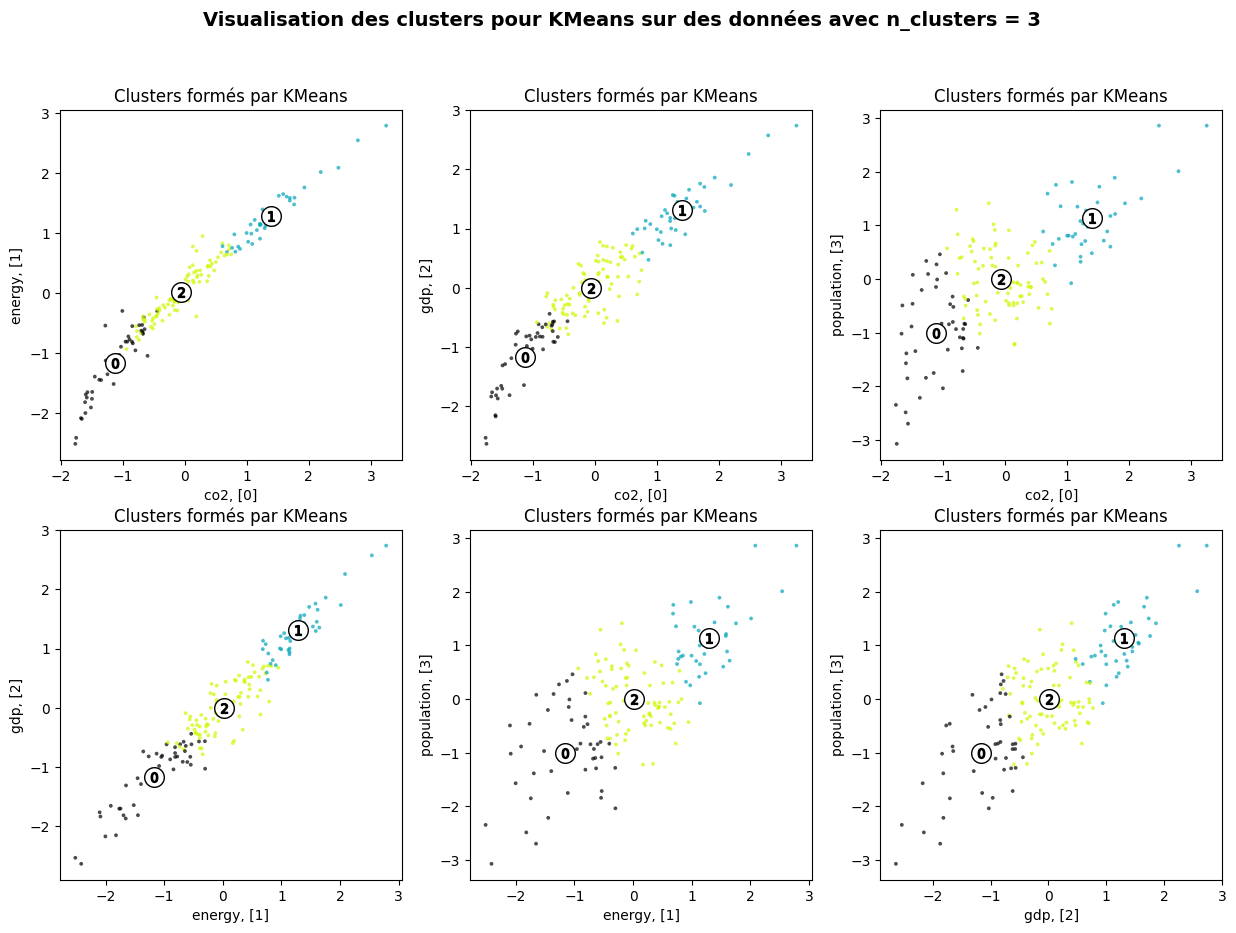

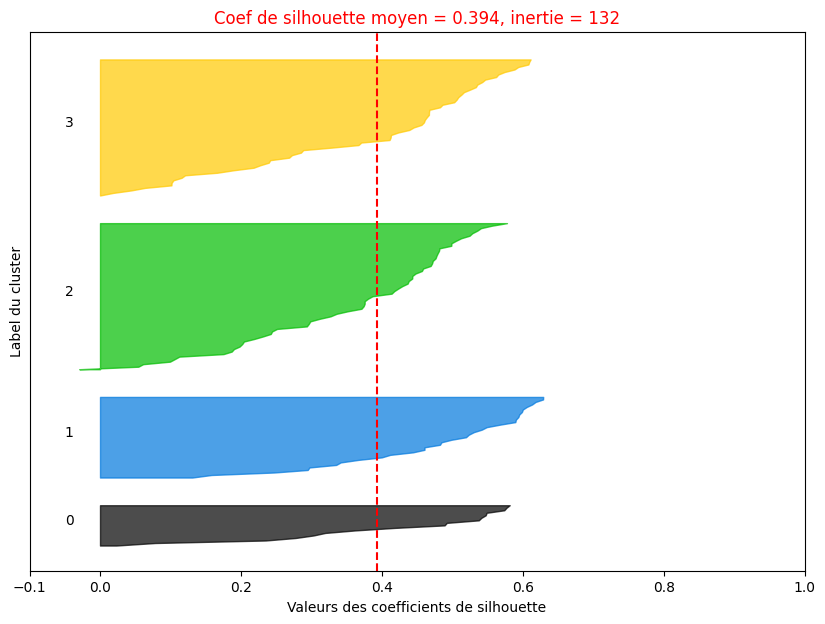

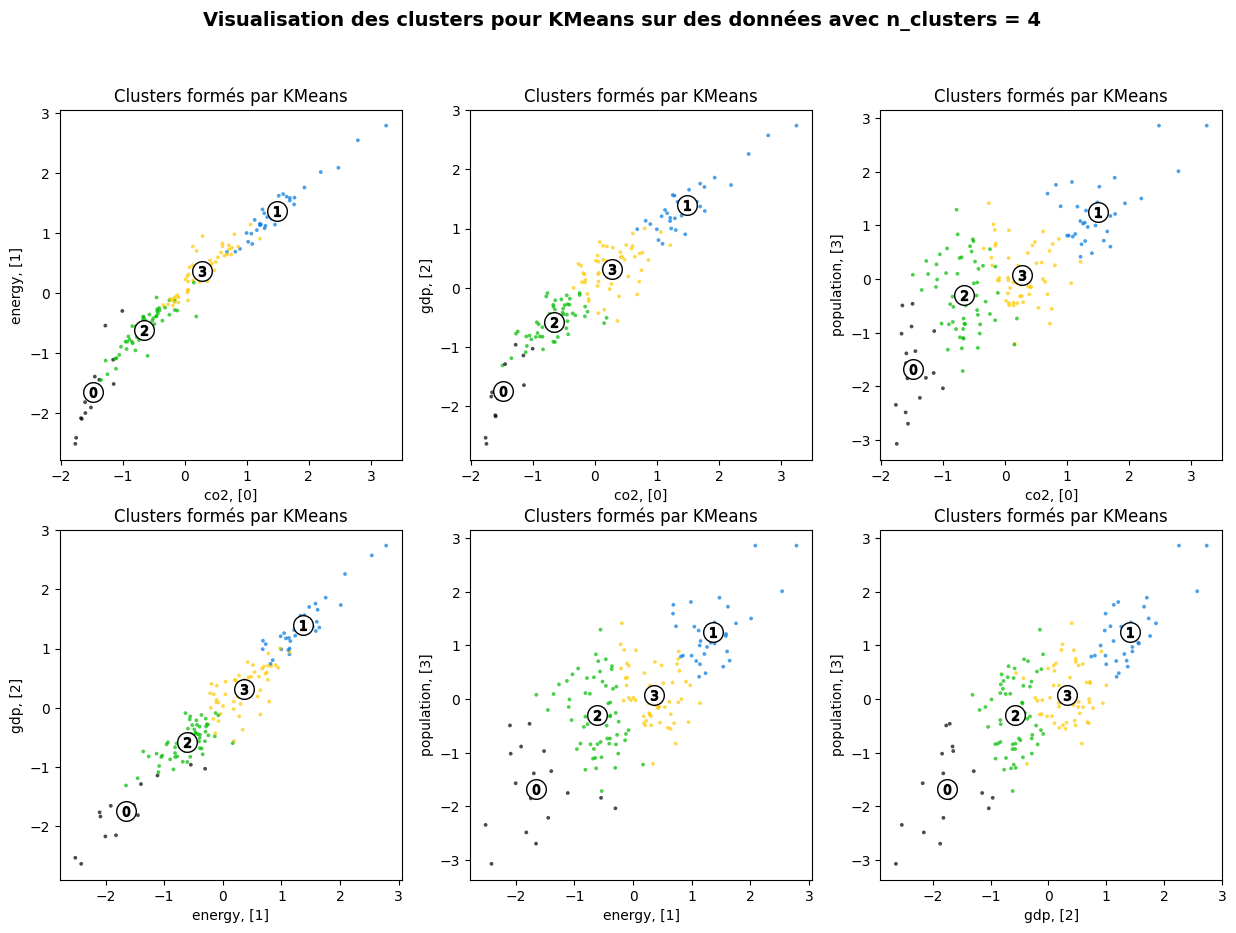

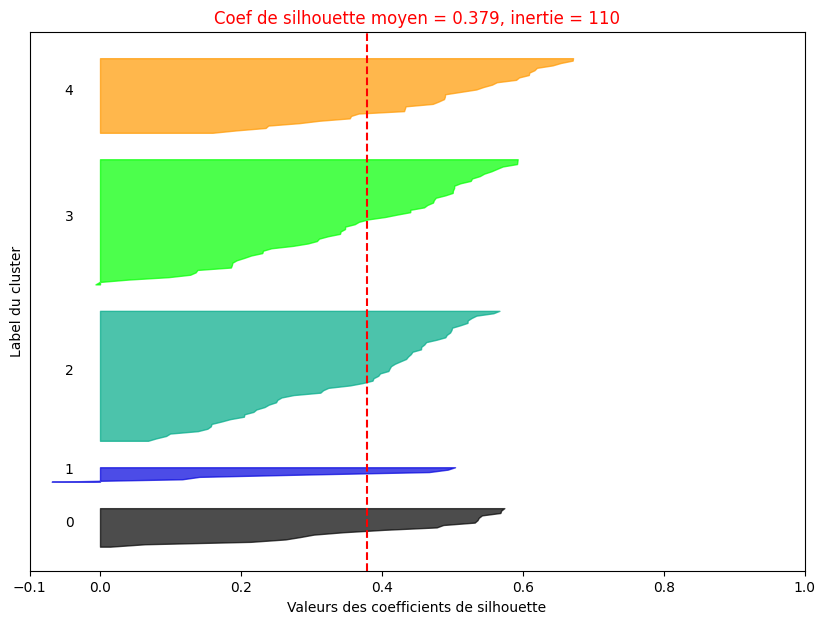

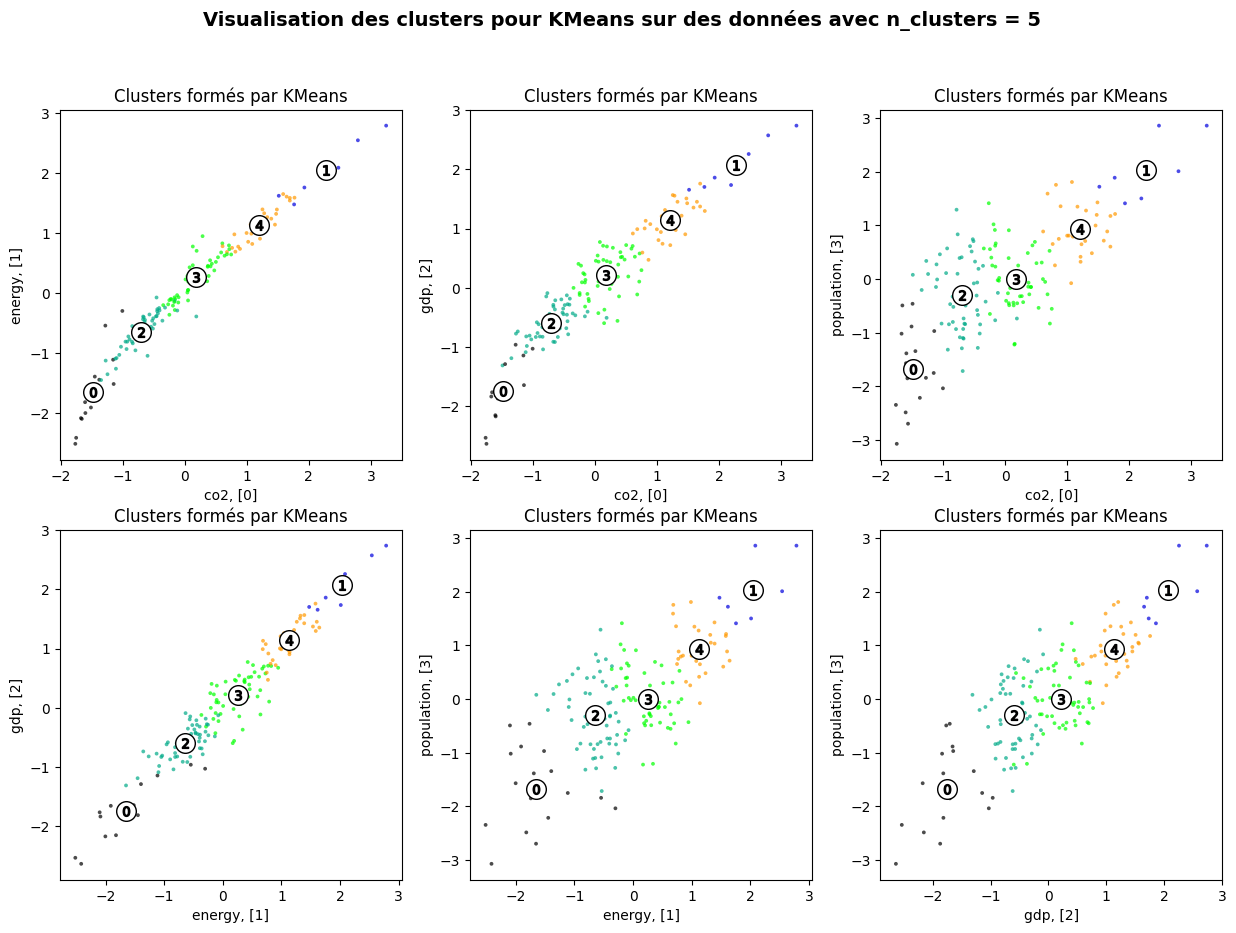

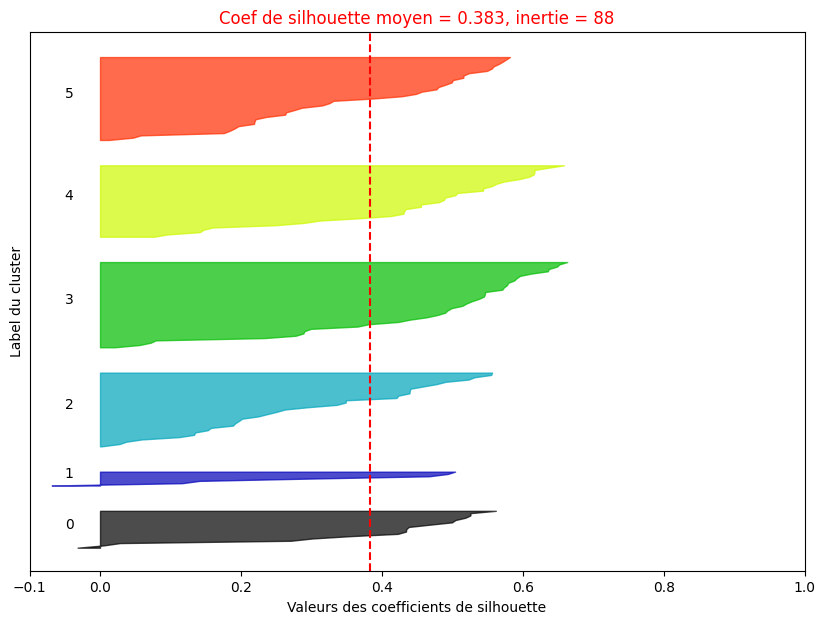

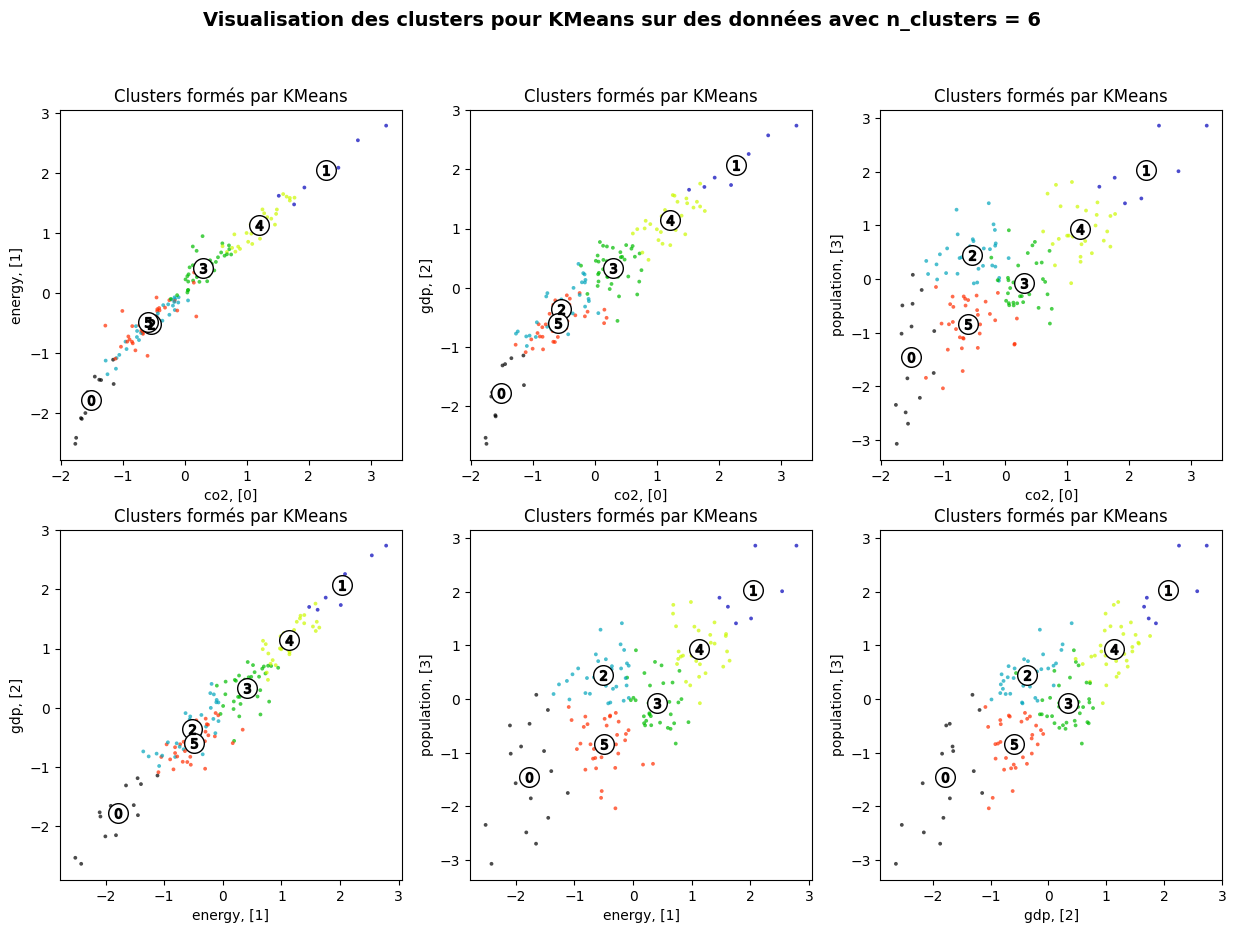

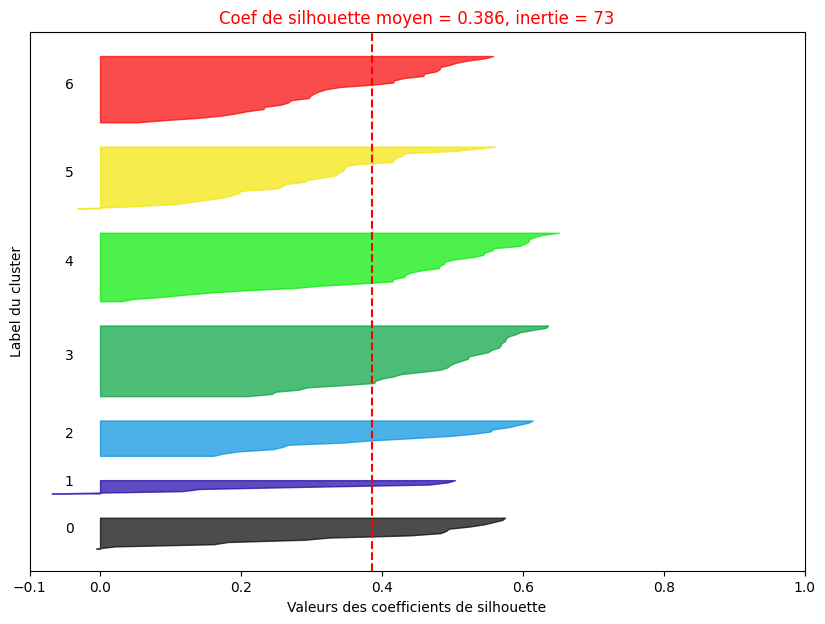

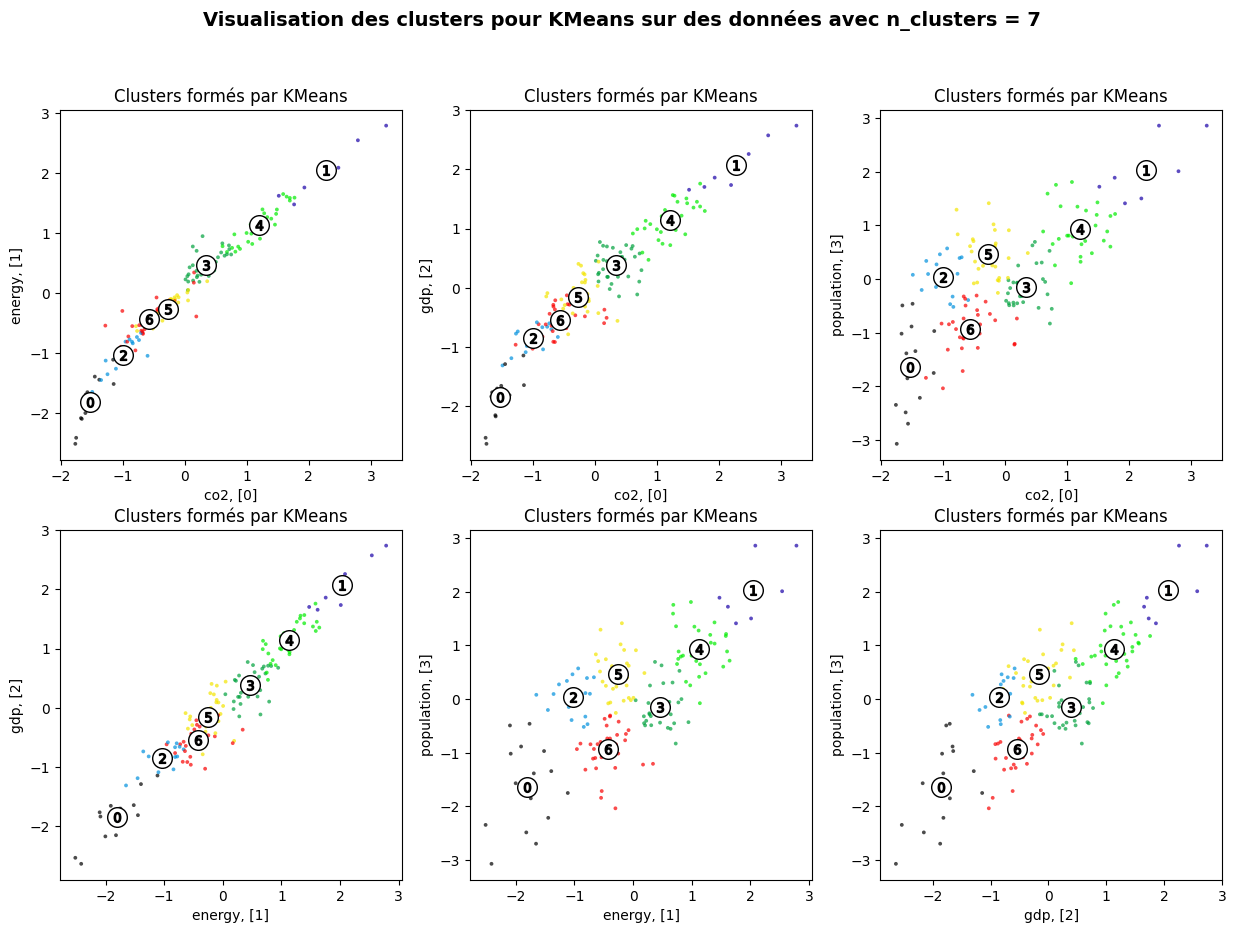

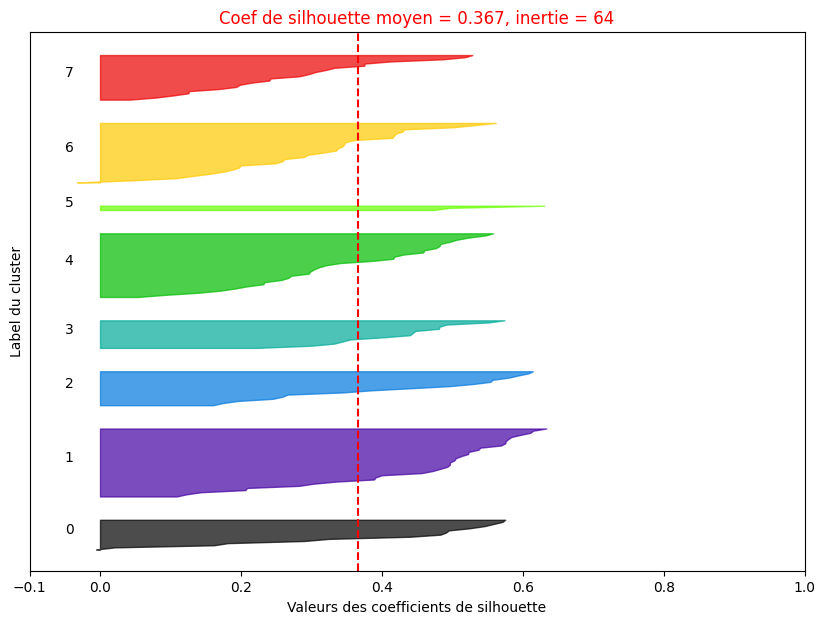

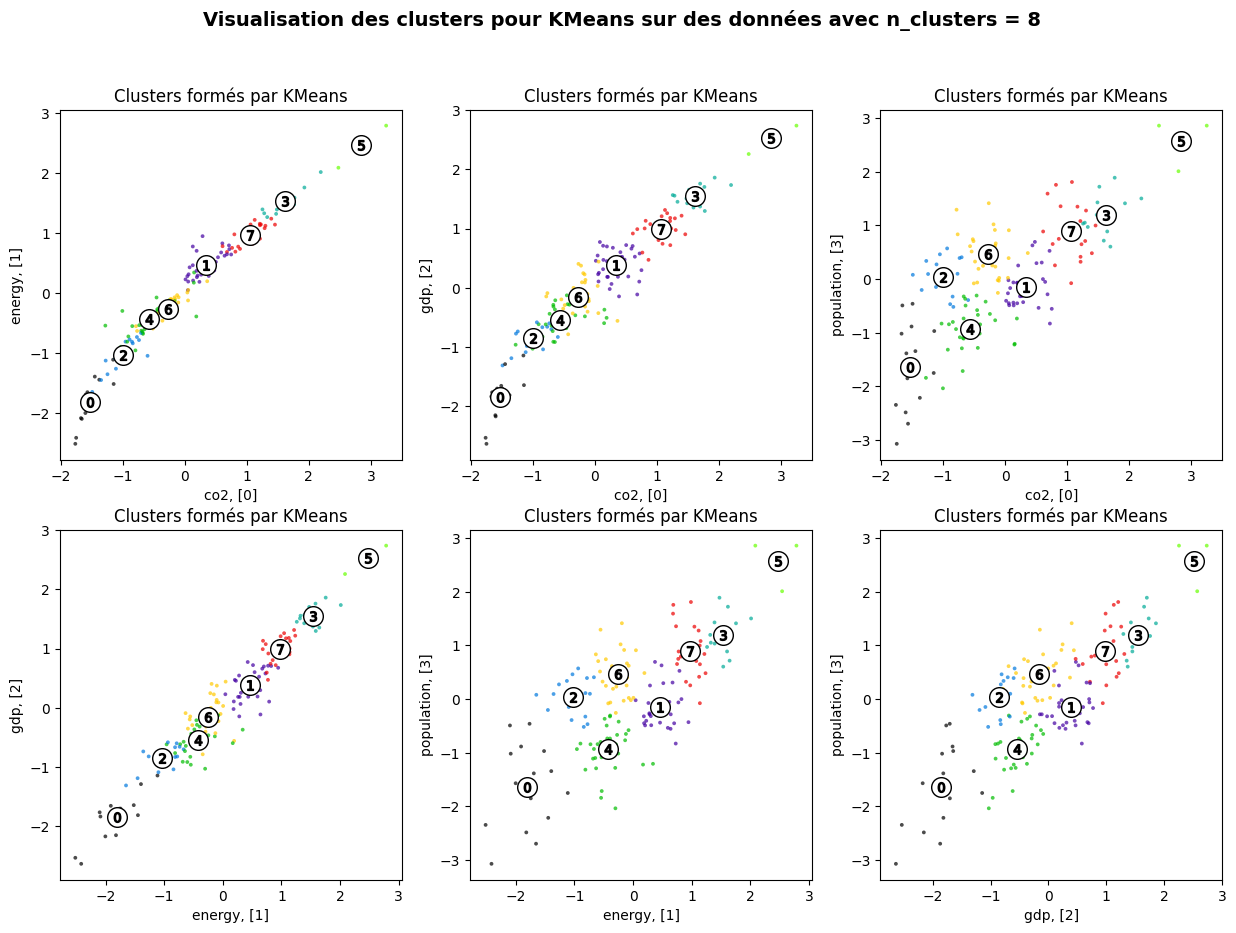

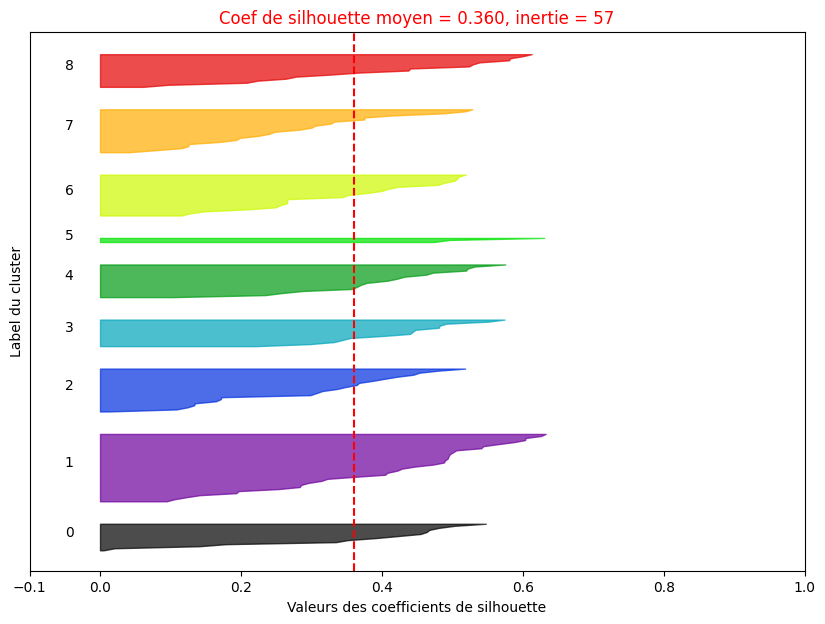

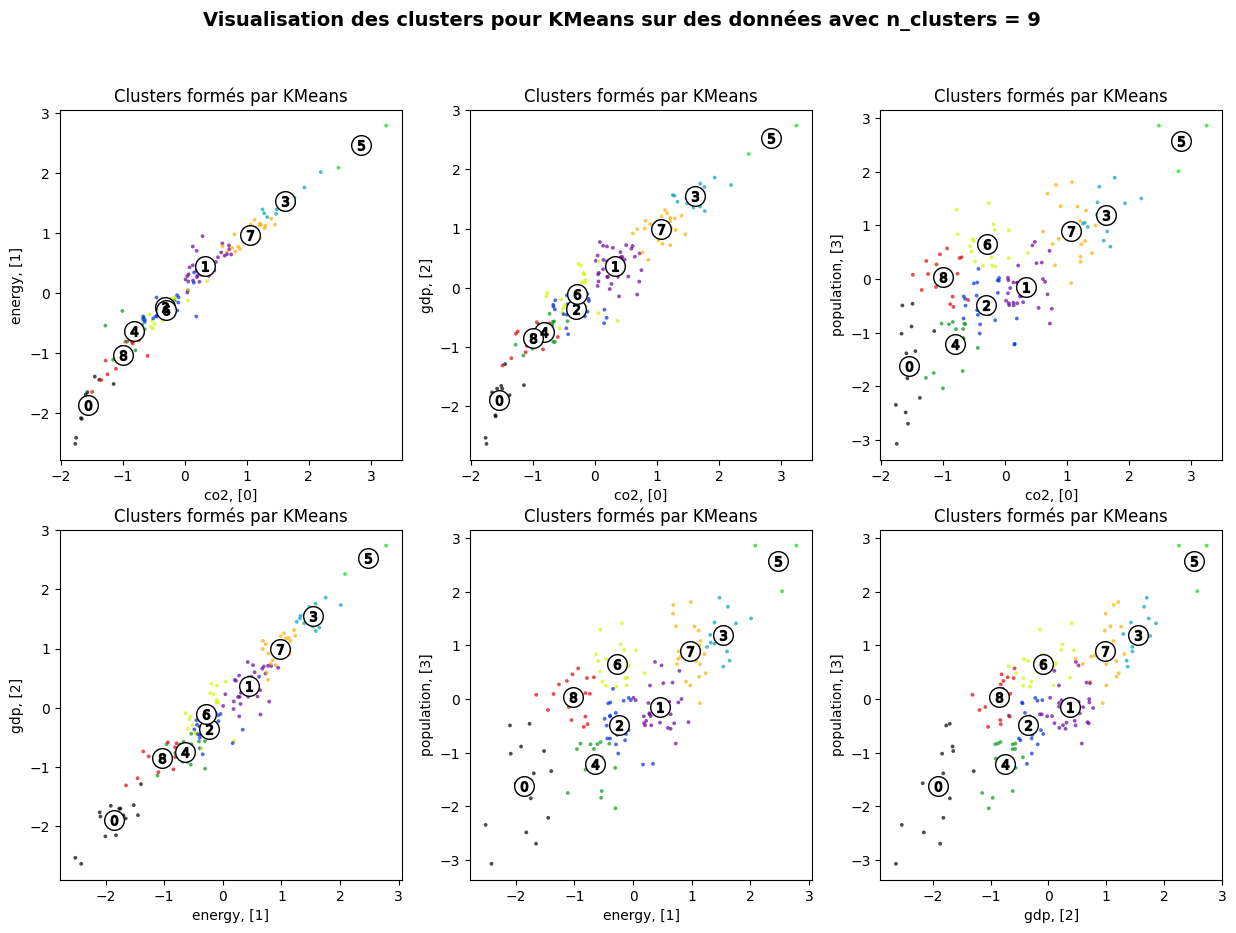

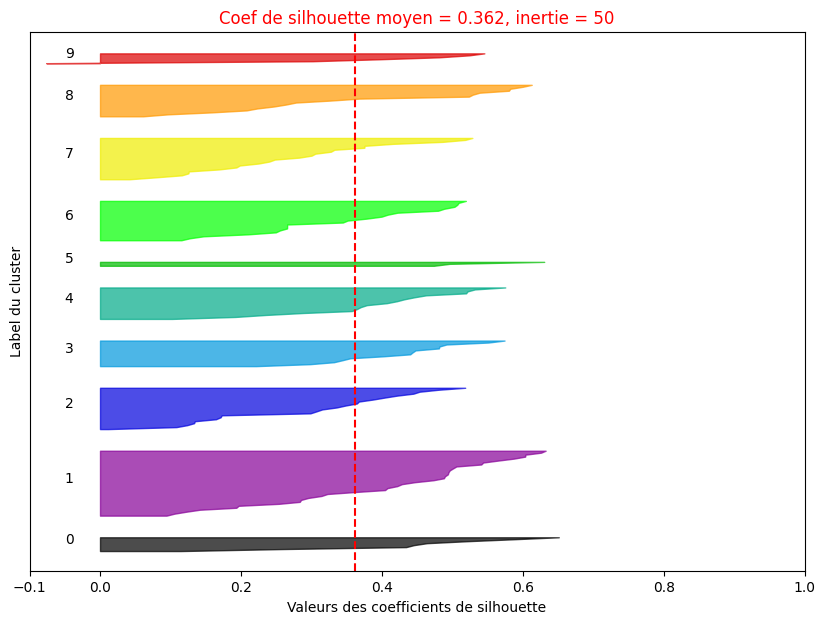

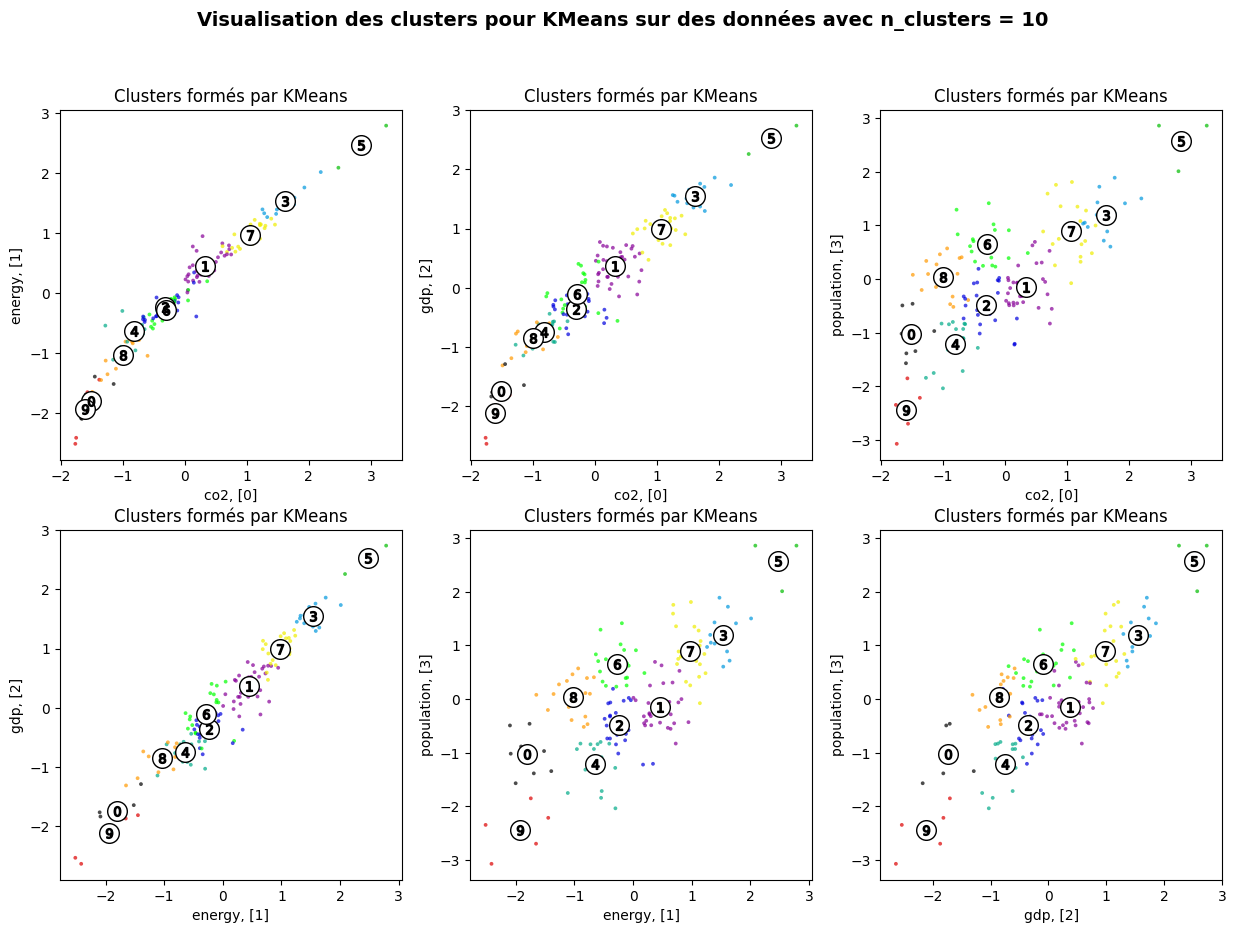

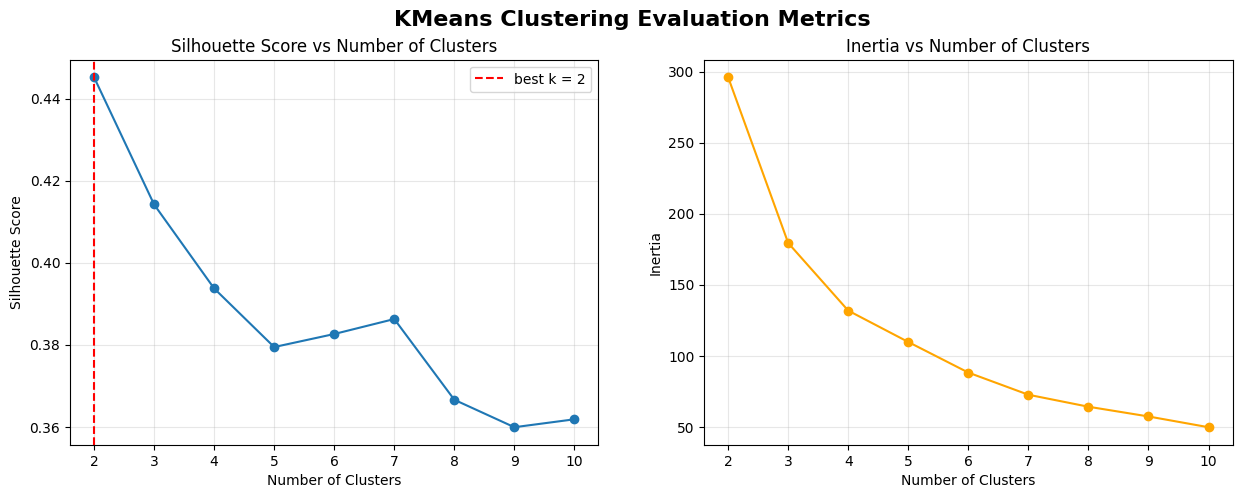